## Feature Engineering

In [237]:
# Enviroment Modules:
import sys
sys.path.append('c:/Users/danrl/Documents/Projects/indicium_project/modules')
from preprocessing import detect_outliers_iqr, remove_outliers_df
from scipy.stats.mstats import winsorize # Replacing with percentile
from scipy.stats import trim_mean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import joblib
import torch
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA

#### Load Data:

In [238]:
data = pd.read_csv("data/data_after_eda.csv", index_col=0)
data.head()

id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  ...  disponibilidade_365  \
0  Entire home/apt    225  ...                  355   
1     Private room    150  ...                  365   
2  Entire home/apt     89  ...                  194   
3  Entire home/apt     80  ...                    0   
4  Entire home/apt    200  ...                  129   

   tempo_desde_ultimo_review trimestre_review  nome_tfidf_mean  w2v_pca_1  \
0                     2089.0           2019Q2         0.000207  -1.917317   
1                     5066.0              NaT         0.000301  -2.630539   
2                     2044.0           2019Q3         0.000273   1.915576   
3                     2272.0           2018Q4         0.000346  -0.932307   
4                     2057.0           2019Q2         0.000319   1.943574   

   w2v_pca_2  w2v_pca_3 w2v_pca_4  w2v_pca_5  nome_sentiment  
0   0.917624   0.196579 -0.838699  -0.167301        0.000000  
1   0.266302   0.485057 -0.063344  -0.830784        0.000000  
2   0.681025  -0.416339 -0.666214   0.566255       -0.100000  
3   0.023822   0.365868 -0.169522   0.005063        0.200000  
4   0.913464   0.496334 -0.130406  -0.387895        0.007143  

[5 rows x 25 columns]

In [239]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48894 entries, 0 to 48893
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48894 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48894 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null  obje

In [240]:
data.describe()

id       host_id      latitude     longitude         price  \
count  4.889400e+04  4.889400e+04  48894.000000  48894.000000  48894.000000   
mean   1.901753e+07  6.762139e+07     40.728951    -73.952169    140.464638   
std    1.098288e+07  7.861118e+07      0.054529      0.046157    105.931059   
min    2.595000e+03  2.438000e+03     40.499790    -74.244420     26.000000   
25%    9.472371e+06  7.822737e+06     40.690100    -73.983070     69.000000   
50%    1.967743e+07  3.079553e+07     40.723075    -73.955680    106.000000   
75%    2.915225e+07  1.074344e+08     40.763117    -73.936273    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990    550.000000   

       minimo_noites  numero_de_reviews  reviews_por_mes  \
count   48894.000000       48894.000000     48894.000000   
mean        5.952878          21.989038         1.089959   
std         8.674536          37.757200         1.575774   
min         1.000000           0.000000         0.000000   
25%         1.000000           1.000000         0.040000   
50%         3.000000           5.000000         0.370000   
75%         5.000000          24.000000         1.580000   
max        30.000000         172.000000        20.000000   

       calculado_host_listings_count  disponibilidade_365  \
count                   48894.000000         48894.000000   
mean                        7.144005           112.776169   
std                        32.952855           131.618692   
min                         1.000000             0.000000   
25%                         1.000000             0.000000   
50%                         1.000000            45.000000   
75%                         2.000000           227.000000   
max                       327.000000           365.000000   

       tempo_desde_ultimo_review  nome_tfidf_mean     w2v_pca_1     w2v_pca_2  \
count               48894.000000     48894.000000  4.889400e+04  4.889400e+04   
mean                 2882.895775         0.000278  4.471931e-07 -1.719660e-07   
std                  1170.265289         0.000046  1.420059e+00  8.931430e-01   
min                  2041.000000         0.000000 -3.875119e+00 -4.171659e+00   
25%                  2060.000000         0.000248 -8.652719e-01 -5.905610e-01   
50%                  2227.000000         0.000284  1.167814e-01  1.296272e-01   
75%                  3242.000000         0.000312  1.007799e+00  5.470451e-01   
max                  5066.000000         0.000571  3.639874e+00  3.807453e+00   

          w2v_pca_3     w2v_pca_4     w2v_pca_5  nome_sentiment  
count  48894.000000  4.889400e+04  48894.000000    48894.000000  
mean       0.000002  1.285420e-07      0.000002        0.207578  
std        0.797278  6.447442e-01      0.552480        0.293523  
min       -1.642348 -3.085760e+00     -2.922023       -1.000000  
25%       -0.570383 -3.834210e-01     -0.307120        0.000000  
50%       -0.189937  1.873443e-02      0.051854        0.068182  
75%        0.385075  4.160649e-01      0.359689        0.400000  
max        4.725468  2.203344e+00      2.890311        1.000000

# Name - Embedding - Extracting information from Textual Data:

#### Buscando responder a questão:
- Existe algum padrão no texto do nome do local para lugares de mais alto valor?

#### BERT

In [241]:
# Carregar o tokenizer e o modelo BERT pré-treinado
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding(text, tokenizer, model):
    # Tokenizar o texto (converter o texto em tokens compatíveis com o BERT)
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=50)

    # Passar os tokens pelo modelo BERT
    with torch.no_grad():  # Desliga o cálculo de gradientes, pois não precisamos treinar o modelo
        outputs = model(**inputs)

    # Obter os embeddings do token [CLS], ou a média dos embeddings das palavras (última camada)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Pegando a média dos embeddings dos tokens

    return embeddings.squeeze().numpy()  # Retorna como vetor numpy

# Testando a função com um exemplo
text = "Luxury apartment with a view"
embedding = get_bert_embedding(text, tokenizer, model)
embedding

array([-2.21066475e-02, -1.93908095e-01,  2.14351639e-01,  2.01491743e-01,
        3.75196189e-01, -3.44903141e-01, -4.62083295e-02,  3.68529320e-01,
       -8.62401724e-03, -4.27618682e-01,  2.19447061e-01, -5.01334071e-01,
       -1.79065868e-01,  1.31586179e-01, -2.45821819e-01, -4.75887120e-01,
        4.79130924e-01,  2.91913062e-01,  1.05188638e-02,  2.88646221e-01,
        3.11631918e-01, -2.14188203e-01, -3.45396787e-01,  4.31495965e-01,
        2.18914464e-01,  2.32409313e-01, -4.11445312e-02,  2.58930862e-01,
       -1.92555979e-01,  7.32724294e-02,  1.25778213e-01,  2.95152552e-02,
       -2.52335042e-01, -7.51447529e-02,  1.01768263e-01, -5.44076264e-01,
        2.95404922e-02, -1.48820803e-01, -5.62870979e-01,  3.76120389e-01,
       -2.22373754e-01, -1.79712176e-01,  8.30092013e-01,  3.29200417e-01,
        8.21826607e-02, -6.79975629e-01,  1.54487208e-01, -2.71710884e-02,
       -6.01670556e-02, -1.71635062e-01,  3.35868537e-01,  3.07548046e-01,
       -4.43953097e-01,  

In [242]:
# Selecionar os primeiros 10 textos
numer_text = 10
texts = data['nome'].head(numer_text)

# Gerar embeddings para os 10 textos
embeddings_list = [get_bert_embedding(text, tokenizer, model) for text in texts]

# Converter a lista de embeddings em um DataFrame
embeddings_df = pd.DataFrame(embeddings_list)

# Adicionar o embeddings_df como novas features no seu DataFrame original
data_10 = pd.concat([data.head(numer_text), embeddings_df], axis=1)

# Visualizando as novas colunas de embeddings
data_10.head()

id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  ...       758       759       760       761  \
0  Entire home/apt    225  ...  0.162532  0.011410 -0.034604 -0.122964   
1     Private room    150  ...  0.232566 -0.252743 -0.076544 -0.564838   
2  Entire home/apt     89  ... -0.157458 -0.284886  0.101637 -0.121031   
3  Entire home/apt     80  ...  0.355868  0.020187 -0.089893 -0.332275   
4  Entire home/apt    200  ...  0.326935 -0.307084 -0.068748 -0.366979   

        762       763       764       765       766       767  
0  0.227338 -0.165019 -0.019998 -0.081421  0.017062 -0.223813  
1 -0.210956 -0.405136 -0.266313 -0.051396  0.206995 -0.499588  
2  0.053966 -0.541285 -0.283562 -0.297737  0.215338 -0.193038  
3 -0.012018 -0.277534  0.002559 -0.311735 -0.036221 -0.068828  
4 -0.016925 -0.253463 -0.029590 -0.147444  0.230542 -0.170553  

[5 rows x 793 columns]

In [243]:
# Reduzindo a dimensionalidade para 50 dimensões
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_df)

# Convertendo o resultado em DataFrame
reduced_embeddings_df = pd.DataFrame(reduced_embeddings)
data_10_pca = pd.concat([data.head(numer_text), reduced_embeddings_df], axis=1)

# Visualizando as novas colunas de embeddings
data_10_pca.head()

id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  ...  trimestre_review  nome_tfidf_mean w2v_pca_1  \
0  Entire home/apt    225  ...            2019Q2         0.000207 -1.917317   
1     Private room    150  ...               NaT         0.000301 -2.630539   
2  Entire home/apt     89  ...            2019Q3         0.000273  1.915576   
3  Entire home/apt     80  ...            2018Q4         0.000346 -0.932307   
4  Entire home/apt    200  ...            2019Q2         0.000319  1.943574   

   w2v_pca_2  w2v_pca_3  w2v_pca_4  w2v_pca_5 nome_sentiment         0  \
0   0.917624   0.196579  -0.838699  -0.167301       0.000000 -0.180255   
1   0.266302   0.485057  -0.063344  -0.830784       0.000000  6.798978   
2   0.681025  -0.416339  -0.666214   0.566255      -0.100000 -1.913600   
3   0.023822   0.365868  -0.169522   0.005063       0.200000 -1.442690   
4   0.913464   0.496334  -0.130406  -0.387895       0.007143 -1.527516   

          1  
0 -1.669779  
1  2.335752  
2  2.126605  
3  0.316017  
4  0.553520  

[5 rows x 27 columns]

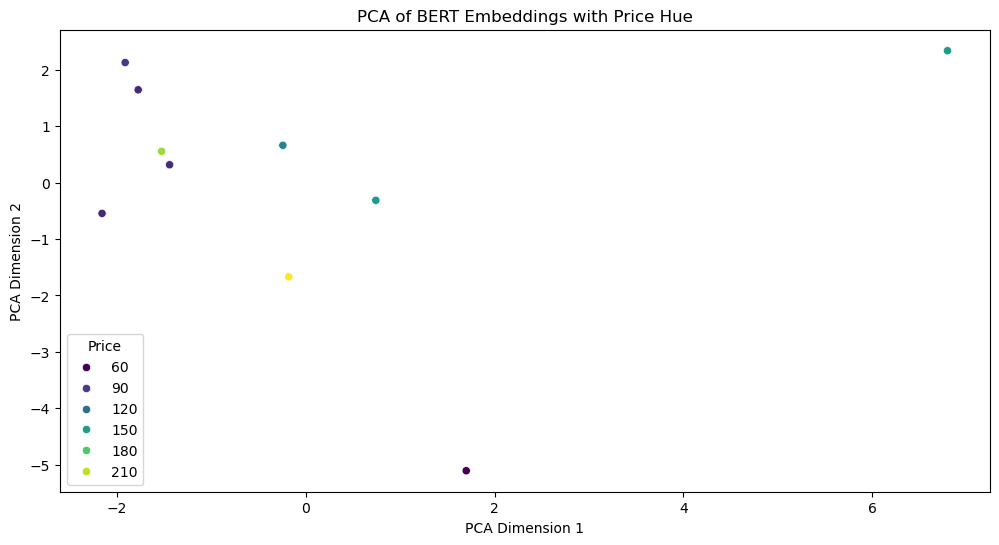

In [244]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=reduced_embeddings_df[0], y=reduced_embeddings_df[1], hue=data.head(numer_text)['price'], palette='viridis')
plt.title('PCA of BERT Embeddings with Price Hue')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend(title='Price')
plt.show()

#### BERT - Embedding All

In [245]:
'''
# Gerar embeddings para os nomes dos imóveis
embeddings_list = []

for name in data['nome']:
    embedding = get_bert_embedding(name, tokenizer, model)
    embeddings_list.append(embedding)

# Converter a lista de embeddings em um DataFrame
embeddings_df = pd.DataFrame(np.array(embeddings_list))

# Adicionar o embeddings_df como novas features no seu DataFrame original
data_em = pd.concat([data, embeddings_df], axis=1)

# Visualizando as novas colunas de embeddings
data_em.head()
'''

"\n# Gerar embeddings para os nomes dos imóveis\nembeddings_list = []\n\nfor name in data['nome']:\n    embedding = get_bert_embedding(name, tokenizer, model)\n    embeddings_list.append(embedding)\n\n# Converter a lista de embeddings em um DataFrame\nembeddings_df = pd.DataFrame(np.array(embeddings_list))\n\n# Adicionar o embeddings_df como novas features no seu DataFrame original\ndata_em = pd.concat([data, embeddings_df], axis=1)\n\n# Visualizando as novas colunas de embeddings\ndata_em.head()\n"

# Lat and Long - Clustering
#### Notes:
- Criando feature de Clustering Com Lat e Long para tentar capturar uma relação conjunta das duas features juntas. Uma vez que Lat sozinha parece descrever menos o comportamento do preço em relação à Long.

In [246]:
from sklearn.cluster import KMeans

# Definir o número de clusters
num_clusters = 20  # Experimente diferentes valores

# Treinar o modelo de clusterização
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data["location_cluster"] = kmeans.fit_predict(data[["latitude", "longitude"]])

# Create a Plotly Express scatter plot, with longitude on the x-axis and latitude on the y-axis, and price on the z-axis, and hue = bairro_group
fig = px.scatter_3d(data, x='longitude', y='latitude', z='price', color='location_cluster', size='price', size_max=10, opacity=1.0, height=600, width=800)
fig.show()

data["location_cluster"].value_counts()

location_cluster
0     5295
7     5035
11    5003
17    4717
1     4426
4     3788
18    3721
14    3237
5     2774
2     2768
13    2140
10    1368
9     1130
6      690
3      644
19     642
8      497
16     442
12     373
15     204
Name: count, dtype: int64

# Pontos de Referência e Distâncias
#### Notes:
- Com base na tese que alguns pontos de referência (lugares nobres de NYC) podem impactar o preço do local, crio um conjunto de pontos de referência para utilizar suas distâncias de cada ponto (Acomodação) como uma feature para predição no preço.

In [247]:
from geopy.distance import geodesic

ny_locations = {
    "manhattan_center": (40.7580, -73.9855),
    "central_park": (40.785091, -73.968285),
    "times_square": (40.758896, -73.985130),
    "wall_street": (40.706001, -74.008801),
    "brooklyn_bridge": (40.706086, -73.996864),
    "empire_state_building": (40.748817, -73.985428),
    "statue_of_liberty": (40.689247, -74.044502),
    "jfk_airport": (40.641311, -73.778139),
    "la_guardia_airport": (40.776927, -73.873965),
    "yankee_stadium": (40.829643, -73.926175),
    "metropolitan_museum": (40.779437, -73.963244),
    "staten_island_greenbelt": (40.588431, -74.139188),
    "ubs_arena": (40.711752, -73.726042),
    "coney_island_beach": (40.572109, -73.979354),
    "bronx_zoo": (40.849896, -73.876733)
}

# Criar features de distância para cada local
for place, coords in ny_locations.items():
    data[f"dist_{place}"] = data.apply(lambda row: geodesic((row["latitude"], row["longitude"]), coords).km, axis=1)

# Criando um DataFrame apenas com as distâncias para salvar
locations_df = data[["latitude", "longitude"] + [f"dist_{place}" for place in ny_locations.keys()]]

# Salvar as features de distância
locations_df.to_csv("feature_store/locations_df_distances.csv", index=False)

# Converter o dicionário `ny_locations` em um DataFrame e salvar como CSV
ny_locations_df = pd.DataFrame.from_dict(ny_locations, orient="index", columns=["latitude", "longitude"])
ny_locations_df.reset_index(names="location_name", inplace=True)  # Adiciona a coluna 'location_name'
ny_locations_df.to_csv("feature_store/locations_df_lat_long.csv", index=False)

# Verificar as novas colunas criadas
data.head()


id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  ...  dist_empire_state_building  \
0  Entire home/apt    225  ...                    0.551442   
1     Private room    150  ...                    7.628745   
2  Entire home/apt     89  ...                    7.396349   
3  Entire home/apt     80  ...                    6.533806   
4  Entire home/apt    200  ...                    0.889855   

   dist_statue_of_liberty dist_jfk_airport  dist_la_guardia_airport  \
0                8.799439        21.391484                 9.625660   
1               15.874246        23.200393                 6.750955   
2                7.177888        16.110981                12.506879   
3               14.808446        22.385154                 6.377911   
4                8.750779        20.404914                 9.128792   

   dist_yankee_stadium  dist_metropolitan_museum  \
0             9.741789                  3.350059   
1             2.646684                  3.746646   
2            16.295626                 10.475698   
3             3.769927                  2.669660   
4             9.992436                  3.664695   

   dist_staten_island_greenbelt dist_ubs_arena  dist_coney_island_beach  \
0                     22.565009      22.262269                20.159783   
1                     29.632441      21.187058                26.498278   
2                     18.593711      19.973084                12.660724   
3                     28.573534      20.773967                25.318448   
4                     22.481785      21.406337                19.499059   

   dist_bronx_zoo  
0       13.996191  
1        7.128933  
2       19.592994  
3        8.047000  
4       14.058555  

[5 rows x 41 columns]

# Embeddings Geográficos (H3)
#### Notes:
- Criando uma feature de Embeddings geográficos para testar o impacto no modelo. 
- Mais uma feature que tenta capturar a relação do local exato com o preço.

In [248]:
import h3
import pandas as pd

# Função para gerar o H3 index a partir das coordenadas
def lat_lon_to_h3(lat, lon, resolution=7):
    return h3.geo_to_h3(lat, lon, resolution)

# Supondo que você tenha um DataFrame 'data' com latitude e longitude
data['h3_index'] = data.apply(lambda row: lat_lon_to_h3(row['latitude'], row['longitude']), axis=1)

# Converter o H3 index para valores numéricos (pode ser feito com hash ou outros métodos)
data['h3_numeric'] = data['h3_index'].apply(lambda x: int(x, 16))  # Convertendo para base 10

# Exibir as novas features
data[['latitude', 'longitude', 'h3_index', 'h3_numeric']].head()

latitude  longitude         h3_index          h3_numeric
0  40.75362  -73.98377  872a100d6ffffff  608725924627611647
1  40.80902  -73.94190  872a1008dffffff  608725923402874879
2  40.68514  -73.95976  872a100daffffff  608725924694720511
3  40.79851  -73.94399  872a1008dffffff  608725923402874879
4  40.74767  -73.97500  872a100d2ffffff  608725924560502783

In [249]:
data.head()

id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  ...  dist_jfk_airport  dist_la_guardia_airport  \
0  Entire home/apt    225  ...         21.391484                 9.625660   
1     Private room    150  ...         23.200393                 6.750955   
2  Entire home/apt     89  ...         16.110981                12.506879   
3  Entire home/apt     80  ...         22.385154                 6.377911   
4  Entire home/apt    200  ...         20.404914                 9.128792   

  dist_yankee_stadium  dist_metropolitan_museum  dist_staten_island_greenbelt  \
0            9.741789                  3.350059                     22.565009   
1            2.646684                  3.746646                     29.632441   
2           16.295626                 10.475698                     18.593711   
3            3.769927                  2.669660                     28.573534   
4            9.992436                  3.664695                     22.481785   

   dist_ubs_arena  dist_coney_island_beach dist_bronx_zoo         h3_index  \
0       22.262269                20.159783      13.996191  872a100d6ffffff   
1       21.187058                26.498278       7.128933  872a1008dffffff   
2       19.973084                12.660724      19.592994  872a100daffffff   
3       20.773967                25.318448       8.047000  872a1008dffffff   
4       21.406337                19.499059      14.058555  872a100d2ffffff   

           h3_numeric  
0  608725924627611647  
1  608725923402874879  
2  608725924694720511  
3  608725923402874879  
4  608725924560502783  

[5 rows x 43 columns]

## Bairro - Average Price
#### Notes:
- Com base nas Análises realizadas no EDA, percebemos que a o preço sofre uma variação e possui uma média diferente entre bairros, mesmo bairros de mesmo grupo.
- Em busca de capturar esta informação de preço médio por bairro, crio uma feature adicionando o preço médio de cada bairro e atribuindo à cada ponto/instância/acomodação. 

In [250]:
# Criar uma feature com o preço médio por bairro
preco_medio_bairro = data.groupby("bairro")["price"].mean()
preco_medio_bairro.head(10)

bairro
Allerton                       87.595238
Arden Heights                  67.250000
Arrochar                      111.428571
Arverne                       156.844156
Astoria                       102.411111
Bath Beach                     81.764706
Battery Park City             214.271429
Bay Ridge                     107.716312
Bay Terrace                   142.000000
Bay Terrace, Staten Island    102.500000
Name: price, dtype: float64

In [251]:
data["preco_medio_bairro"] = data["bairro"].map(preco_medio_bairro)
data.head(10)

id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   
5  5121                                   BlissArtsSpace!     7356   
6  5178                  Large Furnished Room Near B'way      8967   
7  5203                Cozy Clean Guest Room - Family Apt     7490   
8  5238                Cute & Cozy Lower East Side 1 bdrm     7549   
9  5295                  Beautiful 1br on Upper West Side     7702   

     host_name bairro_group              bairro  latitude  longitude  \
0     Jennifer    Manhattan             Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan              Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn        Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan         East Harlem  40.79851  -73.94399   
4        Chris    Manhattan         Murray Hill  40.74767  -73.97500   
5        Garon     Brooklyn  Bedford-Stuyvesant  40.68688  -73.95596   
6     Shunichi    Manhattan      Hell's Kitchen  40.76489  -73.98493   
7    MaryEllen    Manhattan     Upper West Side  40.80178  -73.96723   
8          Ben    Manhattan           Chinatown  40.71344  -73.99037   
9         Lena    Manhattan     Upper West Side  40.80316  -73.96545   

         room_type  price  ...  dist_la_guardia_airport  dist_yankee_stadium  \
0  Entire home/apt    225  ...                 9.625660             9.741789   
1     Private room    150  ...                 6.750955             2.646684   
2  Entire home/apt     89  ...                12.506879            16.295626   
3  Entire home/apt     80  ...                 6.377911             3.769927   
4  Entire home/apt    200  ...                 9.128792             9.992436   
5     Private room     60  ...                12.164253            16.051985   
6     Private room     79  ...                 9.463193             8.734666   
7     Private room     79  ...                 8.341603             4.644542   
8  Entire home/apt    150  ...                12.097966            13.996188   
9  Entire home/apt    135  ...                 8.252746             4.430447   

  dist_metropolitan_museum  dist_staten_island_greenbelt  dist_ubs_arena  \
0                 3.350059                     22.565009       22.262269   
1                 3.746646                     29.632441       21.187058   
2                10.475698                     18.593711       19.973084   
3                 2.669660                     28.573534       20.773967   
4                 3.664695                     22.481785       21.406337   
5                10.296740                     18.967590       19.627139   
6                 2.441629                     23.538579       22.649684   
7                 2.503891                     27.794814       22.688263   
8                 7.678630                     18.738479       22.336385   
9                 2.641007                     28.004074       22.621593   

   dist_coney_island_beach  dist_bronx_zoo         h3_index  \
0                20.159783       13.996191  872a100d6ffffff   
1                26.498278        7.128933  872a1008dffffff   
2                12.660724       19.592994  872a100daffffff   
3                25.318448        8.047000  872a1008dffffff   
4                19.499059       14.058555  872a100d2ffffff   
5                12.897715       19.299119  872a100daffffff   
6                21.413040       13.132489  872a100d6ffffff   
7                25.525057        9.318192  872a10088ffffff   
8                15.722023       17.934281  872a1072dffffff   
9                25.684628        9.107322  872a10088ffffff   

           h3_numeric  preco_

# Room Type - Proportion:
#### Note:
- Com base na Análise que a proporção de tipos de acomodações possuem proporções diferentes em cada bairro e na Tese que isso impacta na preço do local, por trazer características únicas de valorização do bairro. Crio uma feature que carrega a proporção de cada tipo de acomodação em cada bairro, e armazeno em todos os pontos de dados.

In [252]:
room_type_dist = data.groupby(["bairro", "room_type"]).size().unstack(fill_value=0)
room_type_dist = room_type_dist.div(room_type_dist.sum(axis=1), axis=0)

data = data.merge(room_type_dist, on="bairro", how="left")
data.head()

id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  ...  dist_staten_island_greenbelt  dist_ubs_arena  \
0  Entire home/apt    225  ...                     22.565009       22.262269   
1     Private room    150  ...                     29.632441       21.187058   
2  Entire home/apt     89  ...                     18.593711       19.973084   
3  Entire home/apt     80  ...                     28.573534       20.773967   
4  Entire home/apt    200  ...                     22.481785       21.406337   

  dist_coney_island_beach  dist_bronx_zoo         h3_index  \
0               20.159783       13.996191  872a100d6ffffff   
1               26.498278        7.128933  872a1008dffffff   
2               12.660724       19.592994  872a100daffffff   
3               25.318448        8.047000  872a1008dffffff   
4               19.499059       14.058555  872a100d2ffffff   

           h3_numeric  preco_medio_bairro Entire home/apt  Private room  \
0  608725924627611647          253.893204        0.711974      0.273139   
1  608725923402874879          113.234763        0.389767      0.591798   
2  608725924694720511          146.975524        0.604895      0.379371   
3  608725923402874879          121.774396        0.435094      0.524620   
4  608725924560502783          211.734021        0.822680      0.156701   

   Shared room  
0     0.014887  
1     0.018435  
2     0.015734  
3     0.040286  
4     0.020619  

[5 rows x 47 columns]

In [253]:
room_type_dist

room_type        Entire home/apt  Private room  Shared room
bairro                                                     
Allerton                0.380952      0.619048     0.000000
Arden Heights           0.750000      0.250000     0.000000
Arrochar                0.476190      0.523810     0.000000
Arverne                 0.623377      0.350649     0.025974
Astoria                 0.423333      0.548889     0.027778
...                          ...           ...          ...
Windsor Terrace         0.732484      0.267516     0.000000
Woodhaven               0.227273      0.750000     0.022727
Woodlawn                0.363636      0.545455     0.090909
Woodrow                 1.000000      0.000000     0.000000
Woodside                0.268085      0.727660     0.004255

[221 rows x 3 columns]

# Mínimo_Noites
#### Note:
- Criando uma feature categórica derivada do Mínimo de Noites, com base na tese que pode ser melhor tratada para os modelos lineares e de árvores.
- Adicionalmente, a variável categórica pode ajudar na interação com outras variáveis.

<Axes: xlabel='min_nights_category'>

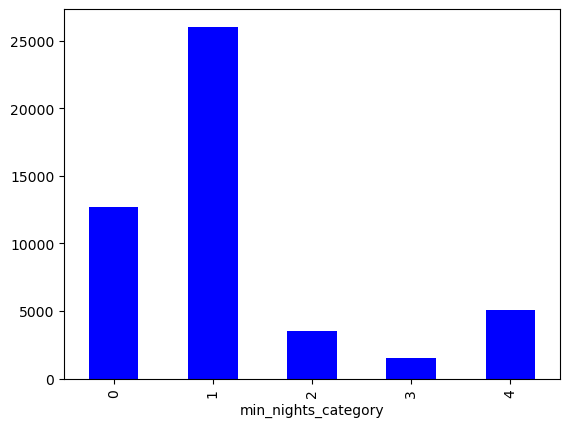

In [254]:
data["min_nights_category"] = pd.cut(data["minimo_noites"], bins=[0, 1, 5, 10, 25, data["minimo_noites"].max()], labels=[0, 1, 2, 3, 4])
data['min_nights_category'].value_counts().sort_index().plot(kind='bar', color='blue')

# Last Review:
#### Note:
- Análise das features de Last Review já criadas na fase de EDA:

## Last Review - Trimestral (Categórica)

<Axes: xlabel='trimestre_review'>

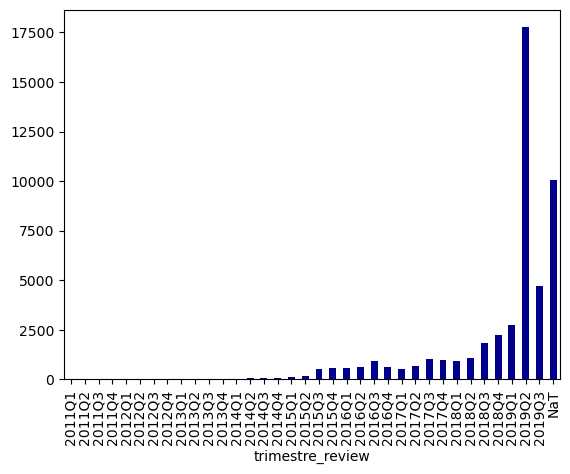

In [255]:
data['trimestre_review'].value_counts().sort_index().plot(kind='bar', color='darkblue')

## Last Review - Tempo em Dias (Numérico)
#### Note:
- Como é o ponto de referência de tempo é o mesmo para todos os últimos Reviews, a data atual foi escolhida como ponto de referência;

<Axes: xlabel='tempo_desde_ultimo_review', ylabel='Count'>

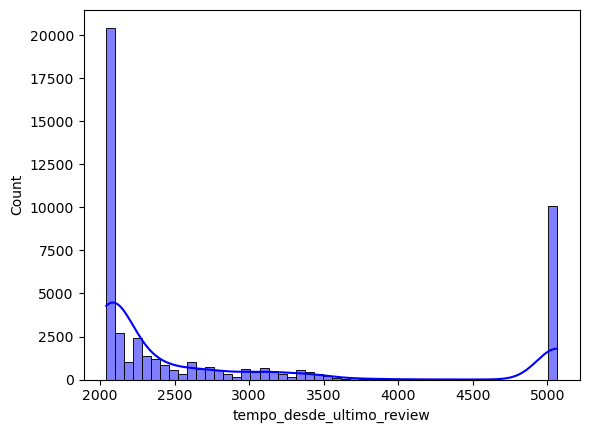

In [256]:
sns.histplot(data["tempo_desde_ultimo_review"], kde=True, bins=50, color='blue')

# Reviews por Mês:

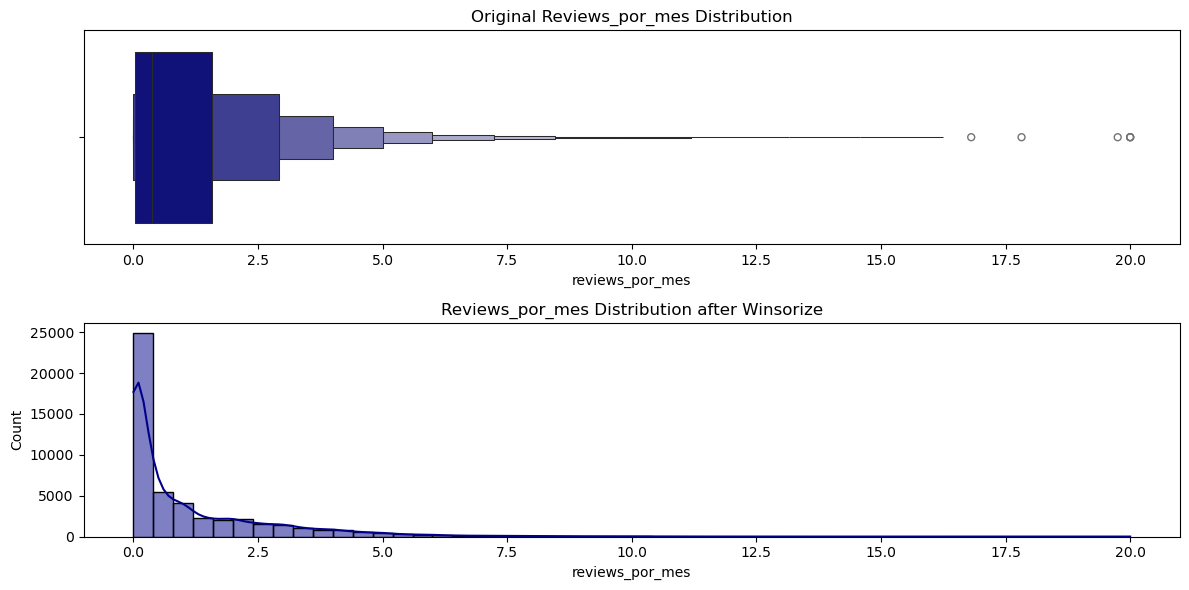

In [257]:
# Cria uma figura com 2 linhas e 1 coluna
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

# Primeiro gráfico: Distribuição original dos reviews_por_mes
sns.boxenplot(data["reviews_por_mes"], color='darkblue', orient='h', ax=axs[0])
axs[0].set_title('Original Reviews_por_mes Distribution')

# Segundo gráfico: Distribuição dos reviews_por_mes após winsorize
sns.histplot(data["reviews_por_mes"], kde=True, bins=50, color='darkblue', ax=axs[1])
axs[1].set_title('Reviews_por_mes Distribution after Winsorize')

# Mostra os gráficos
plt.tight_layout()
plt.show()

## Bairro Group and Room Type - OneHot Encoder

In [258]:
# Create an instance of OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the 'bairro_group' column
encoded_bairro_group = encoder.fit_transform(data[['bairro_group']])

# Convert the result to a DataFrame
encoded_df_bairro_group = pd.DataFrame(encoded_bairro_group, columns=encoder.get_feature_names_out(['bairro_group']))

encoded_df_bairro_group.head()

bairro_group_Bronx  bairro_group_Brooklyn  bairro_group_Manhattan  \
0                 0.0                    0.0                     1.0   
1                 0.0                    0.0                     1.0   
2                 0.0                    1.0                     0.0   
3                 0.0                    0.0                     1.0   
4                 0.0                    0.0                     1.0   

   bairro_group_Queens  bairro_group_Staten Island  
0                  0.0                         0.0  
1                  0.0                         0.0  
2                  0.0                         0.0  
3                  0.0                         0.0  
4                  0.0                         0.0

In [259]:
# Create an instance of OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the 'bairro_group' column
encoded_room_type = encoder.fit_transform(data[['room_type']])

# Convert the result to a DataFrame
encoded_df_room_type = pd.DataFrame(encoded_room_type, columns=encoder.get_feature_names_out(['room_type']))

encoded_df_room_type.head()

room_type_Entire home/apt  room_type_Private room  room_type_Shared room
0                        1.0                     0.0                    0.0
1                        0.0                     1.0                    0.0
2                        1.0                     0.0                    0.0
3                        1.0                     0.0                    0.0
4                        1.0                     0.0                    0.0

# Features Created:

In [260]:
df_price = data[["price"]]
data = data.drop(columns=["price"])

data = pd.concat([data, encoded_df_bairro_group, encoded_df_room_type, df_price], axis=1)
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 56 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   id                             48894 non-null  int64   
 1   nome                           48894 non-null  object  
 2   host_id                        48894 non-null  int64   
 3   host_name                      48894 non-null  object  
 4   bairro_group                   48894 non-null  object  
 5   bairro                         48894 non-null  object  
 6   latitude                       48894 non-null  float64 
 7   longitude                      48894 non-null  float64 
 8   room_type                      48894 non-null  object  
 9   minimo_noites                  48894 non-null  int64   
 10  numero_de_reviews              48894 non-null  int64   
 11  ultima_review                  38842 non-null  object  
 12  reviews_por_mes                4

id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  minimo_noites  ...  min_nights_category  \
0  Entire home/apt              1  ...                    0   
1     Private room              3  ...                    1   
2  Entire home/apt              1  ...                    0   
3  Entire home/apt             10  ...                    2   
4  Entire home/apt              3  ...                    1   

  bairro_group_Bronx  bairro_group_Brooklyn  bairro_group_Manhattan  \
0                0.0                    0.0                     1.0   
1                0.0                    0.0                     1.0   
2                0.0                    1.0                     0.0   
3                0.0                    0.0                     1.0   
4                0.0                    0.0                     1.0   

   bairro_group_Queens  bairro_group_Staten Island room_type_Entire home/apt  \
0                  0.0                         0.0                       1.0   
1                  0.0                         0.0                       0.0   
2                  0.0                         0.0                       1.0   
3                  0.0                         0.0                       1.0   
4                  0.0                         0.0                       1.0   

   room_type_Private room  room_type_Shared room  price  
0                     0.0                    0.0    225  
1                     1.0                    0.0    150  
2                     0.0                    0.0     89  
3                     0.0                    0.0     80  
4                     0.0                    0.0    200  

[5 rows x 56 columns]

## Saving Features:

In [261]:
# Save the preprocessed data:
#data.to_csv("data/data_features_ready.csv", index=False)

## Loading Features:

In [ ]:
data = pd.read_csv("data/data_features_ready.csv", index_col=0)
data

nome   host_id  \
id                                                                      
2595                                  Skylit Midtown Castle      2845   
3647                    THE VILLAGE OF HARLEM....NEW YORK !      4632   
3831                        Cozy Entire Floor of Brownstone      4869   
5022       Entire Apt: Spacious Studio/Loft by central park      7192   
5099              Large Cozy 1 BR Apartment In Midtown East      7322   
...                                                     ...       ...   
36484665    Charming one bedroom - newly renovated rowhouse   8232441   
36485057      Affordable room in Bushwick/East Williamsburg   6570630   
36485431            Sunny Studio at Historical Neighborhood  23492952   
36485609               43rd St. Time Square-cozy single bed  30985759   
36487245  Trendy duplex in the very heart of Hell's Kitchen  68119814   

              host_name bairro_group              bairro  latitude  longitude  \
id                                                                              
2595           Jennifer    Manhattan             Midtown  40.75362  -73.98377   
3647          Elisabeth    Manhattan              Harlem  40.80902  -73.94190   
3831        LisaRoxanne     Brooklyn        Clinton Hill  40.68514  -73.95976   
5022              Laura    Manhattan         East Harlem  40.79851  -73.94399   
5099              Chris    Manhattan         Murray Hill  40.74767  -73.97500   
...                 ...          ...                 ...       ...        ...   
36484665        Sabrina     Brooklyn  Bedford-Stuyvesant  40.67853  -73.94995   
36485057        Marisol     Brooklyn            Bushwick  40.70184  -73.93317   
36485431  Ilgar & Aysel    Manhattan              Harlem  40.81475  -73.94867   
36485609            Taz    Manhattan      Hell's Kitchen  40.75751  -73.99112   
36487245     Christophe    Manhattan      Hell's Kitchen  40.76404  -73.98933   

                room_type  minimo_noites  numero_de_reviews  ...  \
id                                                           ...   
2595      Entire home/apt              1                 45  ...   
3647         Private room              3                  0  ...   
3831      Entire home/apt              1                172  ...   
5022      Entire home/apt             10                  9  ...   
5099      Entire home/apt              3                 74  ...   
...                   ...            ...                ...  ...   
36484665     Private room              2                  0  ...   
36485057     Private room              4                  0  ...   
36485431  Entire home/apt             10                  0  ...   
36485609      Shared room              1                  0  ...   
36487245     Private room              7                  0  ...   

         min_nights_category  bairro_group_Bronx  bairro_group_Brooklyn  \
id                                                                        
2595                       0                 0.0                    0.0   
3647                       1                 0.0                    0.0   
3831                       0                 0.0                    1.0   
5022                       2                 0.0                    0.0   
5099                       1                 0.0                    0.0   
...                      ...                 ...                    ...   
36484665                   1                 0.0                    1.0   
36485057                   1                 0.0                    1.0   
36485431                   2                 0.0                    0.0   
36485609                   0                 0.0                    0.0   
36487245                   2                 0.0                    0.0   

          bairro_group_Manhattan  bairro_group_Queens  \
id                                                      
2595                         1.0                  0.0   
3647               

In [279]:
data_features_num = data.select_dtypes(include=["number"])
data_features_num

host_id  latitude  longitude  minimo_noites  numero_de_reviews  \
id                                                                          
2595          2845  40.75362  -73.98377              1                 45   
3647          4632  40.80902  -73.94190              3                  0   
3831          4869  40.68514  -73.95976              1                172   
5022          7192  40.79851  -73.94399             10                  9   
5099          7322  40.74767  -73.97500              3                 74   
...            ...       ...        ...            ...                ...   
36484665   8232441  40.67853  -73.94995              2                  0   
36485057   6570630  40.70184  -73.93317              4                  0   
36485431  23492952  40.81475  -73.94867             10                  0   
36485609  30985759  40.75751  -73.99112              1                  0   
36487245  68119814  40.76404  -73.98933              7                  0   

          reviews_por_mes  calculado_host_listings_count  disponibilidade_365  \
id                                                                              
2595                 0.38                              2                  355   
3647                 0.00                              1                  365   
3831                 4.64                              1                  194   
5022                 0.10                              1                    0   
5099                 0.59                              1                  129   
...                   ...                            ...                  ...   
36484665             0.00                              2                    9   
36485057             0.00                              2                   36   
36485431             0.00                              1                   27   
36485609             0.00                              6                    2   
36487245             0.00                              1                   23   

          tempo_desde_ultimo_review  nome_tfidf_mean  ...  \
id                                                    ...   
2595                         2089.0         0.000207  ...   
3647                         5066.0         0.000301  ...   
3831                         2044.0         0.000273  ...   
5022                         2272.0         0.000346  ...   
5099                         2057.0         0.000319  ...   
...                             ...              ...  ...   
36484665                     5066.0         0.000285  ...   
36485057                     5066.0         0.000284  ...   
36485431                     5066.0         0.000266  ...   
36485609                     5066.0         0.000311  ...   
36487245                     5066.0         0.000357  ...   

          min_nights_category  bairro_group_Bronx  bairro_group_Brooklyn  \
id                                                                         
2595                        0                 0.0                    0.0   
3647                        1                 0.0                    0.0   
3831                        0                 0.0                    1.0   
5022                        2                 0.0                    0.0   
5099                        1                 0.0                    0.0   
...                       ...                 ...                    ...   
36484665                    1                 0.0                    1.0   
36485057                    1                 0.0                    1.0   
36485431                    2                 0.0                    0.0   
36485609                    0                 0.0                    0.0   
36487245                    2                 0.0                    0.0   

          bairro_group_Manhattan  bairro_group_Queens  \
id                                                      
2595                         1.0                  0.0   
3

In [264]:
data_features_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48894 entries, 2595 to 36487245
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   host_id                        48894 non-null  int64  
 1   latitude                       48894 non-null  float64
 2   longitude                      48894 non-null  float64
 3   minimo_noites                  48894 non-null  int64  
 4   numero_de_reviews              48894 non-null  int64  
 5   reviews_por_mes                48894 non-null  float64
 6   calculado_host_listings_count  48894 non-null  int64  
 7   disponibilidade_365            48894 non-null  int64  
 8   tempo_desde_ultimo_review      48894 non-null  float64
 9   nome_tfidf_mean                48894 non-null  float64
 10  w2v_pca_1                      48894 non-null  float64
 11  w2v_pca_2                      48894 non-null  float64
 12  w2v_pca_3                      48894 non-null

### Features to Use at the HeatMap Bellow:

#### Criteria to Decide Which Feature to use:
- Commum sense/business knowledge
- Numerical features + encoded features

In [289]:
features_num_specific = ["latitude",
            "longitude", 
            "minimo_noites", 
            "numero_de_reviews",
            "reviews_por_mes",
            "calculado_host_listings_count", 
            "disponibilidade_365",
            "tempo_desde_ultimo_review",
            "nome_sentiment", 
            "location_cluster",          # Features numéricas criadas a seção de Feature Engineering:  
            "dist_manhattan_center",
            "dist_central_park",
            "dist_times_square",
            "dist_wall_street",
            "dist_brooklyn_bridge",
            "dist_empire_state_building",
            "dist_statue_of_liberty",
            "dist_jfk_airport",
            "dist_la_guardia_airport",
            "dist_yankee_stadium",
            "dist_metropolitan_museum",
            "dist_staten_island_greenbelt",
            "dist_ubs_arena",
            "dist_coney_island_beach",
            "dist_bronx_zoo",
            "h3_numeric",
            "preco_medio_bairro",
            "Entire home/apt",
            "Private room",
            "Shared room",
            "price"
            ]

#features_num = data.select_dtypes(include=["number"])

# Exibe as primeiras linhas
data_features_num[features_num_specific].head()

latitude  longitude  minimo_noites  numero_de_reviews  reviews_por_mes  \
id                                                                             
2595  40.75362  -73.98377              1                 45             0.38   
3647  40.80902  -73.94190              3                  0             0.00   
3831  40.68514  -73.95976              1                172             4.64   
5022  40.79851  -73.94399             10                  9             0.10   
5099  40.74767  -73.97500              3                 74             0.59   

      calculado_host_listings_count  disponibilidade_365  \
id                                                         
2595                              2                  355   
3647                              1                  365   
3831                              1                  194   
5022                              1                    0   
5099                              1                  129   

      tempo_desde_ultimo_review  nome_sentiment  location_cluster  ...  \
id                                                                 ...   
2595                     2089.0        0.000000                11  ...   
3647                     5066.0        0.000000                18  ...   
3831                     2044.0       -0.100000                 1  ...   
5022                     2272.0        0.200000                18  ...   
5099                     2057.0        0.007143                11  ...   

      dist_staten_island_greenbelt  dist_ubs_arena  dist_coney_island_beach  \
id                                                                            
2595                     22.565009       22.262269                20.159783   
3647                     29.632441       21.187058                26.498278   
3831                     18.593711       19.973084                12.660724   
5022                     28.573534       20.773967                25.318448   
5099                     22.481785       21.406337                19.499059   

      dist_bronx_zoo          h3_numeric  preco_medio_bairro  Entire home/apt  \
id                                                                              
2595       13.996191  608725924627611647          253.893204         0.711974   
3647        7.128933  608725923402874879          113.234763         0.389767   
3831       19.592994  608725924694720511          146.975524         0.604895   
5022        8.047000  608725923402874879          121.774396         0.435094   
5099       14.058555  608725924560502783          211.734021         0.822680   

      Private room  Shared room  price  
id                                      
2595      0.273139     0.014887    225  
3647      0.591798     0.018435    150  
3831      0.379371     0.015734     89  
5022      0.524620     0.040286     80  
5099      0.156701     0.020619    200  

[5 rows x 31 columns]

### HeatMap Correlations:

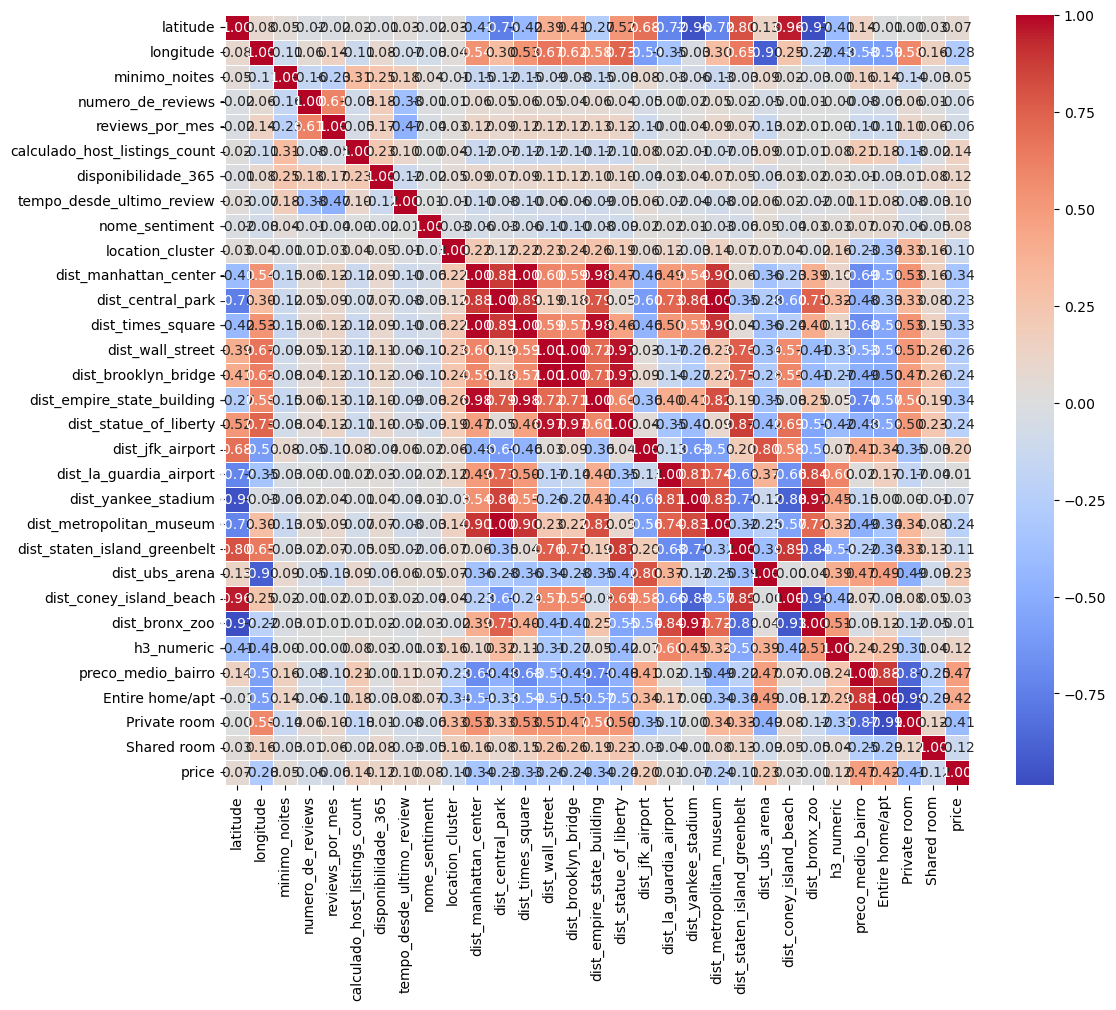

In [290]:
# Calculate the correlation matrix
correlation_matrix = data_features_num[features_num_specific].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

# Show the plot
plt.show()

# Normalization - Scaler Numerical Data:

In [281]:
data_features_num

host_id  latitude  longitude  minimo_noites  numero_de_reviews  \
id                                                                          
2595          2845  40.75362  -73.98377              1                 45   
3647          4632  40.80902  -73.94190              3                  0   
3831          4869  40.68514  -73.95976              1                172   
5022          7192  40.79851  -73.94399             10                  9   
5099          7322  40.74767  -73.97500              3                 74   
...            ...       ...        ...            ...                ...   
36484665   8232441  40.67853  -73.94995              2                  0   
36485057   6570630  40.70184  -73.93317              4                  0   
36485431  23492952  40.81475  -73.94867             10                  0   
36485609  30985759  40.75751  -73.99112              1                  0   
36487245  68119814  40.76404  -73.98933              7                  0   

          reviews_por_mes  calculado_host_listings_count  disponibilidade_365  \
id                                                                              
2595                 0.38                              2                  355   
3647                 0.00                              1                  365   
3831                 4.64                              1                  194   
5022                 0.10                              1                    0   
5099                 0.59                              1                  129   
...                   ...                            ...                  ...   
36484665             0.00                              2                    9   
36485057             0.00                              2                   36   
36485431             0.00                              1                   27   
36485609             0.00                              6                    2   
36487245             0.00                              1                   23   

          tempo_desde_ultimo_review  nome_tfidf_mean  ...  \
id                                                    ...   
2595                         2089.0         0.000207  ...   
3647                         5066.0         0.000301  ...   
3831                         2044.0         0.000273  ...   
5022                         2272.0         0.000346  ...   
5099                         2057.0         0.000319  ...   
...                             ...              ...  ...   
36484665                     5066.0         0.000285  ...   
36485057                     5066.0         0.000284  ...   
36485431                     5066.0         0.000266  ...   
36485609                     5066.0         0.000311  ...   
36487245                     5066.0         0.000357  ...   

          min_nights_category  bairro_group_Bronx  bairro_group_Brooklyn  \
id                                                                         
2595                        0                 0.0                    0.0   
3647                        1                 0.0                    0.0   
3831                        0                 0.0                    1.0   
5022                        2                 0.0                    0.0   
5099                        1                 0.0                    0.0   
...                       ...                 ...                    ...   
36484665                    1                 0.0                    1.0   
36485057                    1                 0.0                    1.0   
36485431                    2                 0.0                    0.0   
36485609                    0                 0.0                    0.0   
36487245                    2                 0.0                    0.0   

          bairro_group_Manhattan  bairro_group_Queens  \
id                                                      
2595                         1.0                  0.0   
3

In [286]:
# Scaling the data
scaler = StandardScaler()

df_price = data_features_num["price"]
data_features_only = data_features_num.drop(columns=["price"])

scaled_features = scaler.fit_transform(data_features_only)

# Save the scaler:
joblib.dump(scaler, 'models/scaler.pkl')

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=data_features_only.columns)

# Converte df_price para DataFrame e redefine o índice
df_price = df_price.reset_index(drop=True)
scaled_df = scaled_df.reset_index(drop=True)

# Concatena os DataFrames corretamente
scaled_df = pd.concat([scaled_df, df_price], axis=1)

scaled_df.head()

host_id  latitude  longitude  minimo_noites  numero_de_reviews  \
0 -0.860173  0.452411  -0.684642      -0.570973           0.609452   
1 -0.860151  1.468387   0.222486      -0.340411          -0.582386   
2 -0.860148 -0.803438  -0.164457      -0.570973           3.973083   
3 -0.860118  1.275645   0.177205       0.466557          -0.344018   
4 -0.860116  0.343295  -0.494637      -0.340411           1.377525   

   reviews_por_mes  calculado_host_listings_count  disponibilidade_365  \
0        -0.450550                      -0.156104             1.840364   
1        -0.691704                      -0.186450             1.916342   
2         2.252910                      -0.186450             0.617121   
3        -0.628243                      -0.186450            -0.856849   
4        -0.317281                      -0.186450             0.123265   

   tempo_desde_ultimo_review  nome_tfidf_mean  ...  min_nights_category  \
0                  -0.678397        -1.555497  ...            -1.017988   
1                   1.865497         0.497060  ...            -0.160430   
2                  -0.716850        -0.120119  ...            -1.017988   
3                  -0.522020         1.476006  ...             0.697127   
4                  -0.705741         0.896101  ...            -0.160430   

   bairro_group_Bronx  bairro_group_Brooklyn  bairro_group_Manhattan  \
0           -0.151072              -0.835607                1.121266   
1           -0.151072              -0.835607                1.121266   
2           -0.151072               1.196735               -0.891849   
3           -0.151072              -0.835607                1.121266   
4           -0.151072              -0.835607                1.121266   

   bairro_group_Queens  bairro_group_Staten Island  room_type_Entire home/apt  \
0            -0.362039                   -0.087678                   0.961394   
1            -0.362039                   -0.087678                  -1.040156   
2            -0.362039                   -0.087678                   0.961394   
3            -0.362039                   -0.087678                   0.961394   
4            -0.362039                   -0.087678                   0.961394   

   room_type_Private room  room_type_Shared room  price  
0               -0.916660              -0.155889    225  
1                1.090917              -0.155889    150  
2               -0.916660              -0.155889     89  
3               -0.916660              -0.155889     80  
4               -0.916660              -0.155889    200  

[5 rows x 47 columns]

## Save the Scaled Data:

In [288]:
# Save the preprocessed data:
scaled_df.to_csv("data/data_features_ready_scaled.csv", index=False)